# Algorytmy macierzowe

## Mnożenie macierzy IGA i FEM

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.sparse
import time
import os

### Konwersja macierzy n x n wygenerowanej w Octave na macierz numpy nq x nq.    
Wynikowa macierz, to macierz Octave powtórzona q razy w poziomie i pionie.

In [2]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+), (\d+)\) -> (\d+\.\d+)\s*", elem)
        if m is not None: # dla macierzy 256x256 dostaje m = None...
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [3]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [4]:
data_dir = "../output"

def resolve_path(matrix_type, width, height = None):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    else: raise FileNotFoundError(f"Matrix file {path} not found")

resolve_matrix = lambda matrix_type, n, m, q = 1: input_matrix(
    load_octave_matrix(resolve_path(matrix_type, n, m)), n, m, q
)

In [5]:
def timeit(times = 1, loops = 2):
    def timed_func(func):
        def wrapper(*args):
            tries_time = 0
            for n_try in range(times):
                loops_time = 0
                for loop in range(loops):
                    t_start = time.time()
                    func(*args)
                    loops_time += time.time() - t_start
                tries_time += loops_time / loops
            return tries_time / times
        return wrapper
    return timed_func

### Sześć algorytmów mnożenia macierzy w zależności od kolejności pętli i, j oraz p.    
A - macierz wejściowa n x m    
B - macierz wejściowa m x k   
C - macierz wynikowa n x k

In [6]:
def matrix_mul_ijp(A, B, C, n, m, k):
    for i in range(n):
        for j in range(m):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]
                    
def matrix_mul_ipj(A, B, C, n, m, k):
    for i in range(n):
        for p in range(k):
            for j in range(m):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jip(A, B, C, n, m, k):
    for j in range(m):
        for i in range(n):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jpi(A, B, C, n, m, k):
    for j in range(m):
        for p in range(k):
            for i in range(n):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pij(A, B, C, n, m, k):
    for p in range(k):
        for i in range(n):
            for j in range(m):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pji(A, B, C, n, m, k):
    for p in range(k):
        for j in range(m):
            for i in range(n):
                 C[i,j] += A[i,p]*B[p,j]

mmul = {
    "warmuprun": matrix_mul_ijp,
    "ijp": matrix_mul_ijp,
    "ipj": matrix_mul_ipj,
    "jip": matrix_mul_jip,
    "jpi": matrix_mul_jpi,
    "pij": matrix_mul_pij,
    "pji": matrix_mul_pji
}

### Macierze wejściowe

In [7]:
SIZE = 256
n = SIZE   # liczba wierszy macierzy A
m = SIZE   # liczba kolumn macierzy A / liczba wierszy macierzy B
k = SIZE   # liczba kolumn macierzy B
q = 2      # czynnik skalujący macierze
N_n = n * q
N_m = m * q
N_k = k * q

In [8]:
A = resolve_matrix("iga", n, m, q)
B = resolve_matrix("fem", m, k, q)
print("Wymiary macierzy A:", A.shape)
print("Wymiary macierzy B:", B.shape)

Wymiary macierzy A: (512, 512)
Wymiary macierzy B: (512, 512)


### Sprawdzanie najszybszego algorytmu

In [14]:
stats = {}

min_loop_time = None
min_mul_type = "ijp"
mmul_optimal = mmul[min_mul_type]

for mul_type, mul_fun in mmul.items():
    print(f"{mul_type}:")
    C = np.zeros((N_n, N_k))
    loop_time = %timeit -n 1 -r 1 -o mul_fun(A, B, C, N_n, N_m, N_k)
    if mul_type == "warmuprun": continue
    stats[mul_type] = loop_time.average
    if min_loop_time is None or min_loop_time > loop_time.average:
        min_loop_time = loop_time.average
        min_mul_type = mul_type
        mmul_optimal = mul_fun

print(f"\nNajszybsza konfiguracja: {min_mul_type}")

warmuprun:
1min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ijp:
1min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ipj:
1min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jip:
1min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jpi:
1min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pij:
1min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pji:
1min 25s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Najszybsza konfiguracja: pij


In [15]:
from IPython.display import Markdown as md
table = """
| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
"""
for loop_order, loop_time in stats.items():
    table += f"|{loop_order}|{loop_time:>.6}|\n"

md(table)


| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
|ijp|84.3998|
|ipj|83.4422|
|jip|83.9876|
|jpi|84.3533|
|pij|83.032|
|pji|85.1829|


### Arbitralny wybór optymalnego algorytmu 

Jeżeli ma zostać wykorzystany algorytm wyznaczony obliczeniowo (w komórce powyżej), nie wykonywać komórki poniżej.

In [16]:
mmul_optimal = mmul["ijp"]

### Sprawdzanie niezerowych miejsc macierzy A, B i C

In [17]:
C = np.zeros((N_n, N_k))
%timeit -n 1 -r 1 mmul_optimal(A, B, C, N_n, N_m, N_k)

1min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


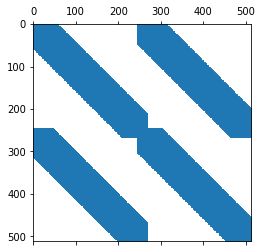

In [18]:
plt.spy(scipy.sparse.csr_matrix(A))
plt.show()

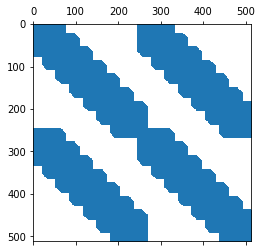

In [19]:
plt.spy(scipy.sparse.csr_matrix(B))
plt.show()

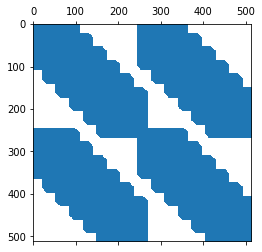

In [20]:
plt.spy(scipy.sparse.csr_matrix(C))
plt.show()

### Mnożenie blokowe macierzy przyjmując wielkość bloków: block_size x block_size.

matrix_mul_fun to jedna z wybranych funkcji mnożenia macierzy zaimplementowanych wyżej

In [21]:
def matrix_block_mul(A, B, C, n, m, k, block_size, matrix_mul_fun):
    for j in range(0, m, block_size):
        j_block = min(m - j, block_size)
        for i in range(0, n, block_size):
            i_block = min(n - i, block_size)
            for p in range(0, k, block_size):
                p_block = min(k - p, block_size)
                matrix_mul_fun(A[i:i + i_block, p:p + p_block], 
                               B[p:p + p_block, j:j + j_block], 
                               C[i:i + i_block, j:j + j_block], 
                               i_block, j_block, p_block)

[4, 8, 16, 32, 64, 128, 256, 512]


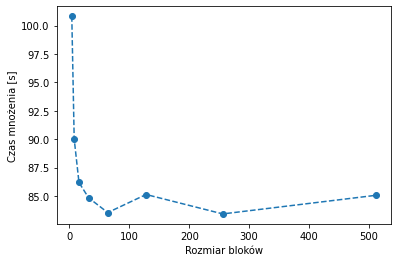

In [22]:
from math import log
block_sizes = [2**i for i in range(2, int(log(N_n * q, 2)))]
print(block_sizes)
mul_time = []
runs = 1

for block_size in block_sizes:
    C = np.zeros((N_n, N_k))
    t0 = time.time()
    for j in range(runs):
        matrix_block_mul(A, B, C, N_n, N_m, N_k, block_size, mmul_optimal)
    mul_time.append((time.time() - t0) / runs)
    
plt.plot(block_sizes, mul_time, linestyle='--')
plt.scatter(block_sizes, mul_time)
plt.xlabel("Rozmiar bloków")
plt.ylabel("Czas mnożenia [s]")
plt.show()

### Liczba operacji zmienno przecinkowych w standardowym algorytmie mnożenia macierzy

Niech $A = [a_{ij}]_{n x m}$, $B = [b_{ij}]_{mxk}$, $C = AB = [c_{ij}]_{nxk}$.

$\forall_{i \in [n], j \in [k]}\, c_{ij} = \sum_{p=1}^{m} a_{ip}b_{pj}$

W powyższej sumie, dla ustalonych $i$, $j$ mamy $m$ mnożeń oraz $m-1$ dodawań -> $2m - 1$ operacji zmienno przecinkowych.

Zatem ogólny koszt algorytmu to $n * k * (2m - 1) = 2nmk - nk$ operacji zmienno-przecinkowych.

### Liczba operacji zmienno przecinkowych w algorytmie blokowego mnożenia macierzy

Niech $A = [a_{ij}]_{n x m} = [A_{ij}]_{NxM}$, $B = [b_{ij}]_{mxk} = [B_{ij}]_{MxK}$, $C = AB = [c_{ij}]_{nxk} = [C_{ij}]_{NxK}$, gdzie przez $A_{ij}$, $B_{ij}$, $C_{ij}$ rozumiemy odpowiednie macierze blokowe rozmiarów, odpowiednio $\frac{n}{N}x\frac{m}{M}$, $\frac{m}{M}x\frac{k}{K}$, $\frac{n}{N}x\frac{k}{K}$.

$\forall_{i \in [N], j \in [K]}\, C_{ij} = \sum_{p=1}^{M} A_{ip}B_{pj}$

Dla ustalonych $i$, $j$ taka suma to $M$ standardowych mnożeń macierzy, z których każde kosztuje $2 * \frac{nkm}{NKM} - \frac{nk}{NK}$ flop oraz $M-1$ dodawań macierzy, z których każde kosztuje $\frac{nk}{NK}$ flop.

Ostatecznie, po rachunkach, otrzymujemy: $2nmk - nk$ flop -- tyle samo co uprzednio.

Zatem w przypadku naszych macierzy, mnożenie ich będzie wymagać następującą liczbę operacji zmiennoprzecinkowych:

In [23]:
n, m = A.shape
_, k = B.shape

print(2 * n * m * k - n * k)

268173312
